In [1]:
import sys
sys.path.append('..')
from scripts.data_analysis import DataAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
original_df = pd.read_csv('../data/updated_data_wave5.csv')

In [5]:
columns_to_extract = [
    'pident', 'eApoB', 'eGp', 'eHDLC', 'eVLDLTG', 'eTotFA', 'eIle', 'eGlc', 'eTyr', 'sex', 'eage',
    'eauditsc', 'esmokstat', 'eipmeto2', 'ecidep09', 'eHSCRP', 'eIL6',
    'eIRSsum9', 'ems_waist', 'ems_hpt', 'ems_trig2', 'ems_hdl2', 'ems_gluc2',
    'emet_syn2', 'etri_med', 'ehdl_med', 'esbp_med', 'edbp_med', 'egluc_med',
    'ebaiscal', 'eids'
]

extracted_df = original_df[columns_to_extract]

extracted_csv_file = '../data/wave5_data_to_discretize.csv'
extracted_df.to_csv(extracted_csv_file, index=False)

In [6]:
def classify_data(df):
    """
    Classify each column in a pandas DataFrame as continuous, discrete, binary, or categorical.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to classify.

    Returns:
    dict: A dictionary with column names as keys and their classifications as values.
    """
    def classify_series(series):
        """
        Classify a pandas Series as continuous, discrete, binary, or categorical.
        
        Parameters:
        series (pd.Series): The Series from a column to classify.

        Returns:
        str: The classification of the series ('continuous', 'discrete', 'binary', 'categorical').
        """
        if pd.api.types.is_numeric_dtype(series):
            unique_count = series.nunique()
            total_count = len(series)
            
            if unique_count == 2:
                return 'binary'
            elif unique_count < 10:
                return 'discrete'
            else:
                return 'continuous'
        else:
            return 'categorical'

    column_classifications = {col: classify_series(df[col]) for col in df.columns}
    return column_classifications

In [7]:
data = pd.read_csv('../data/wave5_data_to_discretize.csv')

In [8]:
# replace -1 in columns with NaN
columns_with_minus_one = [
    'eHSCRP', 'eIL6', 'ems_waist', 'ems_hpt', 'ems_trig2', 'ems_hdl2', 'ems_gluc2',
    'emet_syn2'
]
for col in columns_with_minus_one:  
  data[col] = data[col].replace(-1, np.nan)

data['eIRSsum9'] = data[col].replace(-3, np.nan)
data['eIRSsum9'] = data[col].replace(-2, np.nan)

In [9]:
column_types = classify_data(data)
column_types

{'pident': 'continuous',
 'eApoB': 'continuous',
 'eGp': 'continuous',
 'eHDLC': 'continuous',
 'eVLDLTG': 'continuous',
 'eTotFA': 'continuous',
 'eIle': 'continuous',
 'eGlc': 'continuous',
 'eTyr': 'continuous',
 'sex': 'binary',
 'eage': 'continuous',
 'eauditsc': 'continuous',
 'esmokstat': 'discrete',
 'eipmeto2': 'continuous',
 'ecidep09': 'binary',
 'eHSCRP': 'continuous',
 'eIL6': 'continuous',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'continuous',
 'ehdl_med': 'continuous',
 'esbp_med': 'continuous',
 'edbp_med': 'continuous',
 'egluc_med': 'continuous',
 'ebaiscal': 'continuous',
 'eids': 'continuous'}

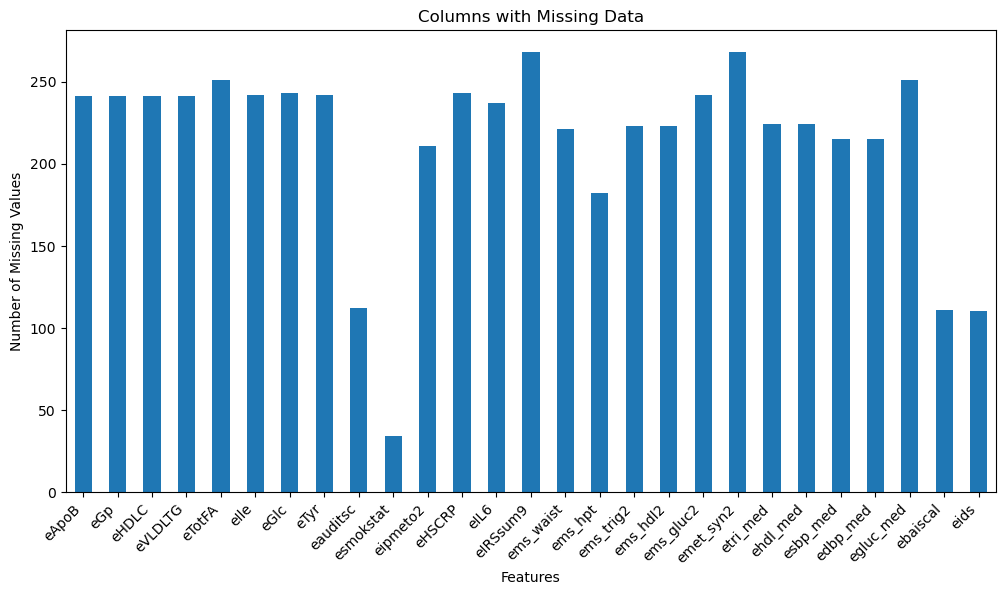

In [10]:
DataAnalysis.plot_missing_values(data)

In [11]:
from scipy.stats import chi2_contingency

def perform_little_mcar_test(df):
    results = []

    for col_with_missing_data in df.columns[df.isnull().any()]:
        # Create a mask indicating where data is missing
        missing_data = df[col_with_missing_data ].isnull().astype(int)

        # Create contingency table for Chi-Squared test
        contingency_table = pd.crosstab(missing_data, df.drop(columns=[col_with_missing_data]).isnull().any(axis=1).astype(int))

        # Perform Chi-Squared test
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table, correction=False)

        # Append results
        results.append({'Column': col_with_missing_data, 'Chi-Squared': chi2_stat, 'df': dof, 'p-value': p_val})

    return pd.DataFrame(results)

perform_little_mcar_test(data)

,Column,Chi-Squared,df,p-value
0,eApoB,801.872268,1,2.113474e-176
1,eGp,801.872268,1,2.113474e-176
2,eHDLC,801.872268,1,2.113474e-176
3,eVLDLTG,801.872268,1,2.113474e-176
4,eTotFA,797.947640,1,1.507585e-175
5,eIle,805.599340,1,3.270914e-177
6,eGlc,802.344037,1,1.668884e-176
7,eTyr,805.599340,1,3.270914e-177
8,eauditsc,327.959290,1,2.674612e-73
9,esmokstat,1.601926,1,2.056305e-01


Data is not missing completely at random so we cannot discard it

In [12]:
columns_to_process = [col for col in columns_to_extract if col != 'pident']

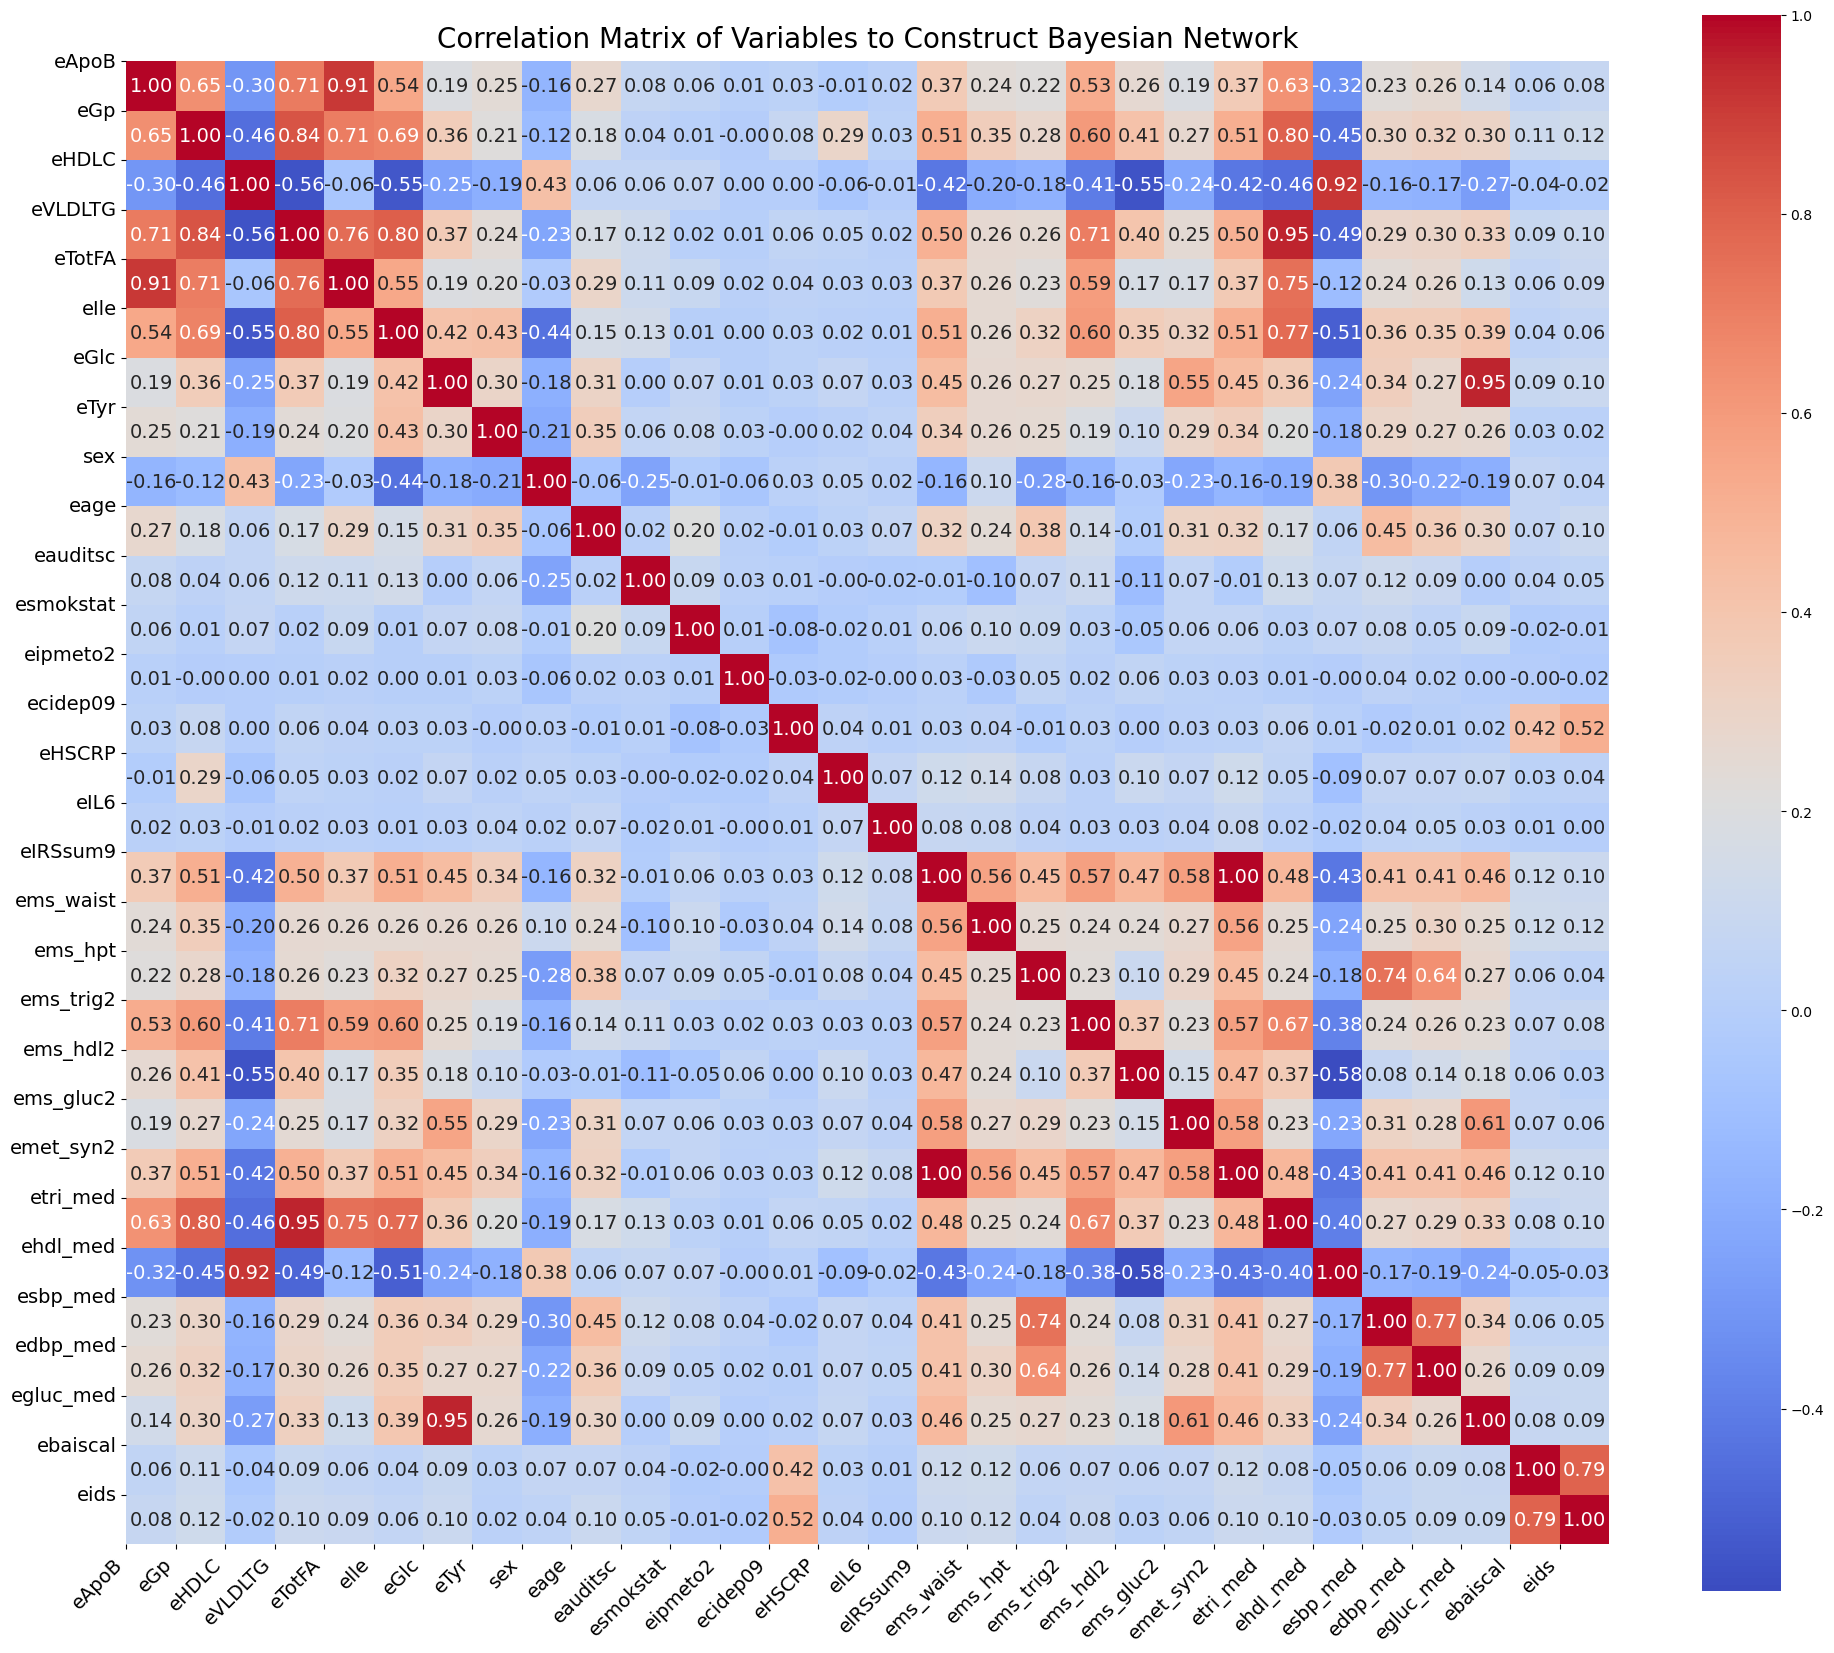

In [13]:
DataAnalysis.plot_correlation_matrix(data[columns_to_process], columns_to_process, 'Variables to Construct Bayesian Network')

Now, we are going to impute the missing data with MICE

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

def multiple_imputation(df, column_types, max_iter=10):
    variable_importance = {}

    rf_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=max_iter, random_state=42)

    imputed_df = df.copy()

    if 'emet_syn2' in df.columns:
        correlated_vars = ['ems_trig2', 'ems_hdl2', 'ems_hpt', 'ems_gluc2', 'etri_med', 'ehdl_med', 'esbp_med', 'edbp_med', 'egluc_med']
        imputation_vars = ['emet_syn2'] + correlated_vars
        data_for_imputation = df[imputation_vars]

        imputed_data = rf_imputer.fit_transform(data_for_imputation)
        # convert to binary
        imputed_df['emet_syn2'] = np.round(imputed_data[:, 0]).astype(int)

    for col in df.columns[df.isnull().any()]:
        if col == 'emet_syn2':
            continue

        imputed_data = rf_imputer.fit_transform(df[[col]])
        imputed_df[col] = imputed_data[:, 0]

        if column_types[col] == 'binary':
            imputed_df[col] = np.round(imputed_df[col]).astype(int)

        # Assess variable importance
        if col not in variable_importance:
            rf_estimator = RandomForestRegressor()
            rf_estimator.fit(df.dropna().drop(col, axis=1), df.dropna()[col])
            importances = rf_estimator.feature_importances_
            feature_importances = {feature: importance for feature, importance in zip(df.dropna().drop(col, axis=1).columns, importances)}
            variable_importance[col] = feature_importances

    return imputed_df, variable_importance

In [15]:
imputed_df, variable_importance = multiple_imputation(data[columns_to_process], column_types, max_iter=10)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
DataAnalysis.plot_missing_values(imputed_df)

No missing values


In [17]:
classify_data(imputed_df)

{'eApoB': 'continuous',
 'eGp': 'continuous',
 'eHDLC': 'continuous',
 'eVLDLTG': 'continuous',
 'eTotFA': 'continuous',
 'eIle': 'continuous',
 'eGlc': 'continuous',
 'eTyr': 'continuous',
 'sex': 'binary',
 'eage': 'continuous',
 'eauditsc': 'continuous',
 'esmokstat': 'discrete',
 'eipmeto2': 'continuous',
 'ecidep09': 'binary',
 'eHSCRP': 'continuous',
 'eIL6': 'continuous',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'continuous',
 'ehdl_med': 'continuous',
 'esbp_med': 'continuous',
 'edbp_med': 'continuous',
 'egluc_med': 'continuous',
 'ebaiscal': 'continuous',
 'eids': 'continuous'}

In [18]:
imputed_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)
imputed_df['pident'] = data['pident']
imputed_df.set_index('pident', inplace=True)

In [19]:
imputed_df.to_csv('../data/network/imputed_data_wave5.csv')

## Transform continuous variables to discrete

In [20]:
preprocessed_df = pd.read_csv('../data/network/imputed_data_wave5.csv')

In [21]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def apply_kmeans(df, column_name, n_clusters=3, random_state=0):
    data = df[column_name].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    
    centroids = kmeans.cluster_centers_
    sorted_idx = np.argsort(centroids.ravel())

    # 1 for "Low", 2 for "Moderate", 3 for "High"
    ordinal_labels = {old_label: new_label for old_label, new_label in zip(sorted_idx, range(1, n_clusters + 1))}
    df[column_name] = [ordinal_labels[x] for x in kmeans.labels_]
    
    colors = ['#3B28CC', '#3F8EFC', '#ADD7F6']
    plt.figure(figsize=(8, 6))
    for label in range(1, n_clusters + 1):
        subset = df[df[f'{column_name}'] == label]
        plt.hist(subset[f'{column_name}'], bins=np.arange(1, n_clusters + 2) - 0.5, color=colors[label-1], label=f'Cluster {label}', alpha=0.75, edgecolor='black')

    plt.title(f'Clusters of {column_name}')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(range(1, n_clusters + 1))
    plt.legend()
    plt.show()
    
    return df

In [22]:
#eApoB
bins = [-float('inf'), 1.3, float('inf')]
# Low: 1, High: 2
labels = [1, 2]
preprocessed_df['eApoB'] = pd.cut(preprocessed_df['eApoB'], bins=bins, labels=labels, right=False)
preprocessed_df['eApoB'].unique()

[1, 2]
Categories (2, int64): [1 < 2]

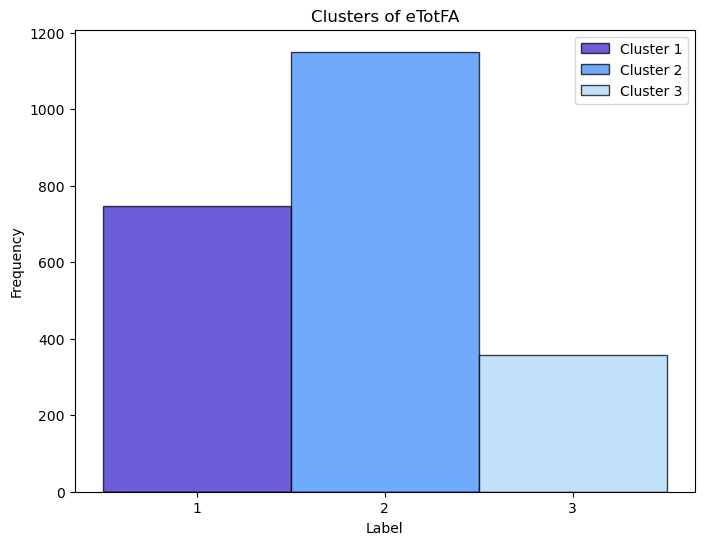

In [23]:
#eTotFA
preprocessed_df = apply_kmeans(preprocessed_df, 'eTotFA', n_clusters=3, random_state=0)

In [24]:
preprocessed_df['eHDLC'] = preprocessed_df.apply(
    lambda row: 1 if (row['sex'] == 1 and row['eHDLC'] > 1.03) or (row['sex'] == 2 and row['eHDLC'] > 1.29) else 2,
    axis=1
)
# Desirable: 1, At risk: 2

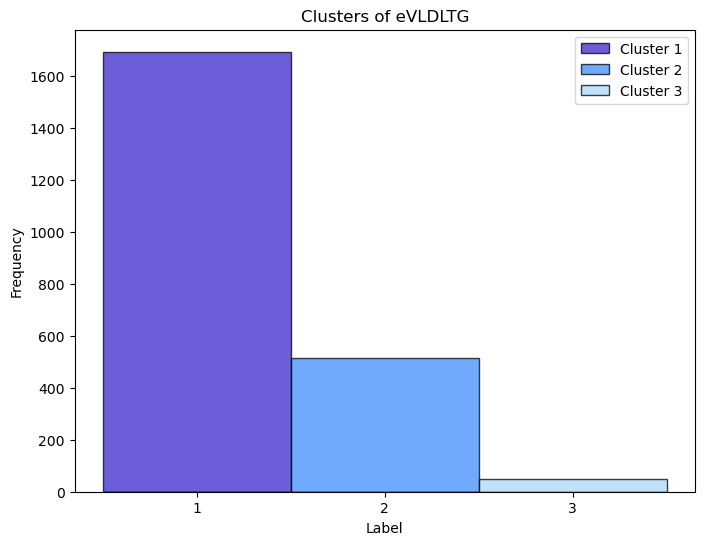

In [36]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eVLDLTG', n_clusters=3, random_state=0)

In [37]:
preprocessed_df['eGp'] = preprocessed_df['eGp'].apply(lambda x: 1 if x <= 1.2 else 2)
preprocessed_df['eGp'].unique()
# Normal: 1, At risk: 2

array([2, 1])

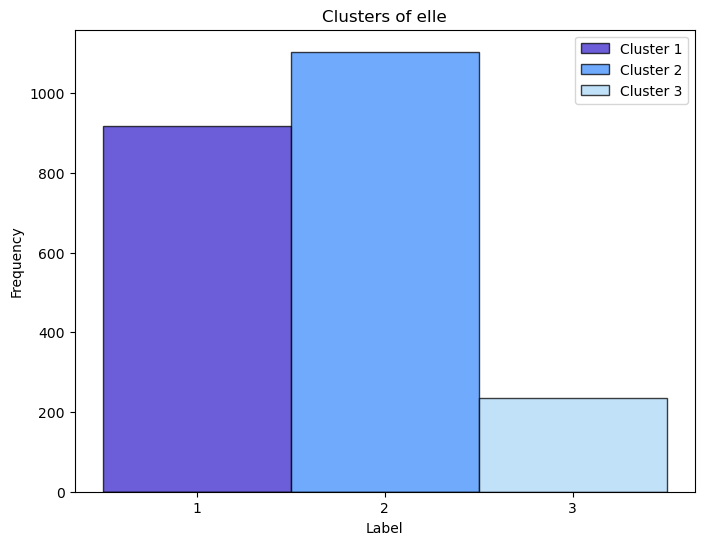

In [38]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eIle', n_clusters=3, random_state=0)

In [45]:
#eGlc
bins = [-float('inf'), 3.5, 6.0, 7.5, float('inf')]
# Low: 1, Normal: 2, Prediabetes: 3, Chronic: 4
labels = [1, 2, 3, 4]
preprocessed_df['eGlc'] = pd.cut(preprocessed_df['eGlc'], bins=bins, labels=labels, right=False)
preprocessed_df['eGlc'].unique()

[2, 1, 4, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

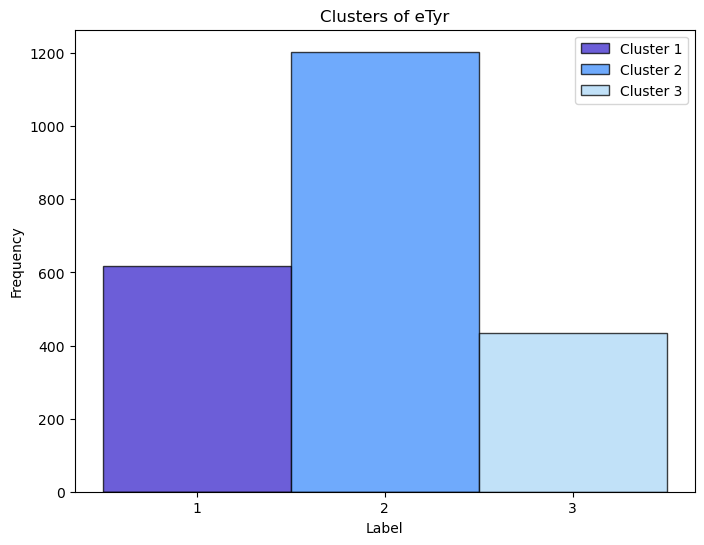

In [48]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eTyr', n_clusters=3, random_state=0)

In [49]:
def categorize_met(met):
    moderate = 4.9 * 60 * 3 # assuming 3 sessions of 1 hour each per week
    vigorous = 6.8 * 60 * 3
    if met >= moderate and met < vigorous:  
        return 2 # Moderate
    elif met >= 6.8 * 60 * 3: 
        return 3 # Vigorous
    else:
        return 1 # Low

preprocessed_df['eipmeto2'] = preprocessed_df['eipmeto2'].apply(categorize_met)
print(preprocessed_df['eipmeto2'].value_counts())

eipmeto2
3    1880
1     263
2     113
Name: count, dtype: int64


In [50]:
preprocessed_df['eIL6'] = pd.cut(preprocessed_df['eIL6'],
                                bins=[-float('inf'), 7, float('inf')],
                                labels=[1, 2], # Normal: 1, High: 2
                                right=True) 

print(preprocessed_df['eIL6'].value_counts())

eIL6
1    2205
2      51
Name: count, dtype: int64


In [51]:
preprocessed_df['eHSCRP'] = pd.cut(preprocessed_df['eHSCRP'],
                                  bins=[-float('inf'), 0.3, 1, 10, 50, float('inf')],
                                  labels=[1, 2, 3, 4, 5], 
                                  right=False)
print(preprocessed_df['eHSCRP'].value_counts())


eHSCRP
3    1276
2     655
1     247
4      75
5       3
Name: count, dtype: int64


In [52]:
def categorize_atri_med(row):
    adult_threshold = 150 * 0.01129  # mg/dL to mmol/L for adults
    child_threshold = 90 * 0.01129   # mg/dL to mmol/L for children and teens

    if row['eage'] > 19:
        if row['etri_med'] < adult_threshold:
            return 1 # Healthy
        else:
            return 2 # High
    else: 
        if row['etri_med'] < child_threshold:
            return 1 # Healthy
        else:
            return 2 # High

preprocessed_df['etri_med'] = preprocessed_df.apply(categorize_atri_med, axis=1)
print(preprocessed_df['etri_med'].value_counts())

etri_med
1    1821
2     435
Name: count, dtype: int64


In [53]:
def categorize_ahdl_med(row):
    if row['sex'] == 1: 
        return 1 if row['ehdl_med'] > 1.0 else 2
    elif row['sex'] == 2: 
        return 1 if row['ehdl_med'] > 1.2 else 2

preprocessed_df['ehdl_med'] = preprocessed_df.apply(categorize_ahdl_med, axis=1)
preprocessed_df['ehdl_med'].value_counts()
# Healthy: 1, Unhealthy: 2

ehdl_med
1    1935
2     321
Name: count, dtype: int64

In [54]:
def categorize_blood_pressure(df):
    for index, row in df.iterrows():
        sbp = row['esbp_med']
        dbp = row['edbp_med']
        
        if sbp < 122 and dbp < 80:
            df.at[index, 'esbp_med'] = 1
            df.at[index, 'edbp_med'] = 1
        elif 120 <= sbp <= 129 and dbp < 80:
            df.at[index, 'esbp_med'] = 2
            df.at[index, 'edbp_med'] = 2
        elif (130 <= sbp <= 139 or 80 <= dbp <= 89):
            df.at[index, 'esbp_med'] = 3
            df.at[index, 'edbp_med'] = 3
        elif sbp >= 140 or dbp >= 90:
            df.at[index, 'esbp_med'] = 4
            df.at[index, 'edbp_med'] = 4
        else:
            df.at[index, 'esbp_med'] = -1
            df.at[index, 'edbp_med'] = -1

categorize_blood_pressure(preprocessed_df)
# Normal: 1, Elevated: 2, Hypertension I: 3, Hypertension II: 4, Uncategorized: -1

In [55]:
def categorize_glucose_level(glucose_mmol):
    glucose_mg_dl = glucose_mmol * 18  # convert mmol/L to mg/dL
    if glucose_mg_dl < 70:
        return 1 # Hypoglycemia
    elif 70 <= glucose_mg_dl <= 100:
        return 2 # Normal
    elif 100 < glucose_mg_dl <= 125:
        return 3 # Prediabetes
    elif glucose_mg_dl >= 126:
        return 4 # Diabetes
    else:
        return -1

preprocessed_df['egluc_med'] = preprocessed_df['egluc_med'].apply(categorize_glucose_level)

preprocessed_df['egluc_med'].value_counts()

egluc_med
2    1521
3     591
4     141
1       3
Name: count, dtype: int64

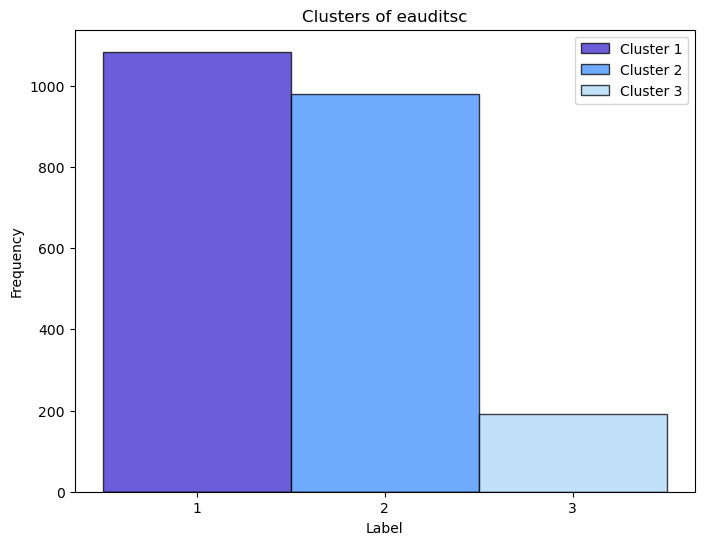

In [56]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eauditsc', n_clusters=3, random_state=0)

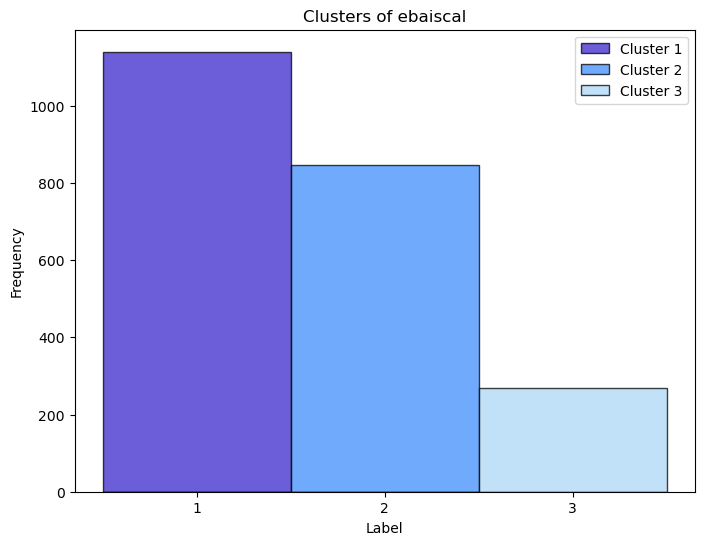

In [57]:
preprocessed_df = apply_kmeans(preprocessed_df, 'ebaiscal', n_clusters=3, random_state=0)

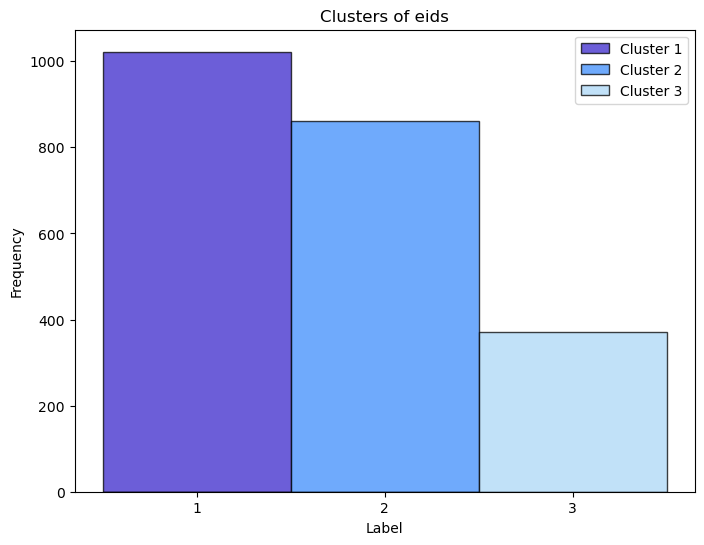

In [58]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eids', n_clusters=3, random_state=0)

In [59]:
def discretize_age(data, column, bins, labels):
    bin_indices = np.digitize(data[column], bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(labels) - 1)
    return [labels[i] for i in bin_indices]

In [60]:
bins = [18, 26, 45, 60, float('inf')]
labels = [1, 2, 3, 4] # Young adult (18-25 age), Adult (26-44 age), Middle-age (45-59 age), Old age (60+ age)
preprocessed_df['eage'] = discretize_age(preprocessed_df, 'eage', bins, labels)

In [63]:
# save data to build the network
preprocessed_df.to_csv('../data/network/updated_discrete_wave5.csv', index=False)

In [64]:
final_data = pd.read_csv('../data/network/updated_discrete_wave5.csv')
classify_data(final_data[columns_to_process])

{'eApoB': 'binary',
 'eGp': 'binary',
 'eHDLC': 'binary',
 'eVLDLTG': 'discrete',
 'eTotFA': 'discrete',
 'eIle': 'discrete',
 'eGlc': 'discrete',
 'eTyr': 'discrete',
 'sex': 'binary',
 'eage': 'discrete',
 'eauditsc': 'discrete',
 'esmokstat': 'discrete',
 'eipmeto2': 'discrete',
 'ecidep09': 'binary',
 'eHSCRP': 'discrete',
 'eIL6': 'binary',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'binary',
 'ehdl_med': 'binary',
 'esbp_med': 'discrete',
 'edbp_med': 'discrete',
 'egluc_med': 'discrete',
 'ebaiscal': 'discrete',
 'eids': 'discrete'}

In [65]:
wave1 = pd.read_csv('../data/network/updated_discrete_wave1.csv')
wave5 = pd.read_csv('../data/network/updated_discrete_wave5.csv')

merged_df = pd.merge(wave1, wave5, on='pident', how='inner')
merged_df = merged_df.drop(columns=['pident'])
merged_df.to_csv('../data/updated_discrete_data.csv', index=False)

Merged data has been saved to discrete_mice.csv
